# Datenerhebung und Visualisierung zum Projekt Bildschirmplatzoptimierung

Dieses Jupyter Notebook vereint den Code zur Datenerhebung bishin zur Visualisierung dieser. Dieses Dokument dient lediglich zum besseren Verständnis der vorgelegten Hausarbeit und schildert die Vorgehensweise unserer Analyse. 

Die folgende Arbeit ist in drei Teile geteilt:

 - Teil A - Datenerhebung
 - Teil B - Datenvisualisierung
 


### Datenerhebung

Die folgende Sensorprogrammierung wurde in Pycharm, mit Verwendung von Micropython geschrieben und ausgeführt. Der Code wurde zu Übersichtszwecken in dieses Jupyter Notebook aufgenommen. In diesem Hauptprogramm werden die verschiedenen Sensoren aufgerufen, Daten gesammelt und anschließend an Amazon AWS übertragen. 

In [1]:
import machine
from machine import RTC, Pin
import json
import time
from time import sleep

import wifi
import mqtt

# Importieren der Klassen HCSR04 und ldr von Bibliotheken des Ultraschall- und Fotowiderstandssensors.
from HC_SR04 import HCSR04
from ldr import LDR

# Definieren der Thema, an der die Daten gesendet werden.
MQTT_TOPIC = "measurements-topic"

# Definieren der Funktion zum Konvertieren des Zeitstempels.
def convert_to_iso(datetime):
    y, m, d, _, h, mi, s, _ = datetime
    return "{}-{:02d}-{:02d}T{:02d}:{:02d}:{:02d}".format(y,m,d,h,mi,s)

# Definieren der Funktion, die die Messung der Distanz anhand der Funktion "distance_cm" aus der Klasse HCSR04 initiiert.
def measure_distance_data():
    sensor = HCSR04(trigger_pin=19, echo_pin=23, echo_timeout_us=1000000)
    sensor.distance_cm()
    return sensor.distance_cm()

# Definieren der Funktion zum Publizieren der vom Ultraschallsensor aufgenommenen Distanzdaten in der Thema.
def publish_distance_data(mqtt_client):
    data = measure_distance_data()
    iso_timestamp = convert_to_iso(RTC().datetime())

    message = {'distance': data,
               'timestamp': iso_timestamp}
    mqtt_client.publish(MQTT_TOPIC, json.dumps(message))

""" Definieren der Funktion, die anhand der Funktion "value" aus der Klasse "ldr" den von dem Fotowiderstandssenor
    gelesenen Rohwert einem Wert zuordnet, der innerhalb eines vorausbestimmten Bereich "min und max" liegt."""
def measure_light_data():
    ldr = LDR(34)
    ldr.value()
    return ldr.value()

# Definieren der Funktion zum Publizieren der Daten aus dem Fotowiderstandssenor in der Thema.
def publish_light_data(mqtt_client):
    data = measure_light_data()
    iso_timestamp = convert_to_iso(RTC().datetime())

    message = {'light': data,
               'timestamp': iso_timestamp}
    mqtt_client.publish(MQTT_TOPIC, json.dumps(message))

"""Definieren der Funktion für die LED-Warnung. Abhängig der gemessenen Distanz leutet das LED in drei verschiedenen
    Farben - rot, blau und grün."""
def led_warnung():
    sensor = HCSR04(trigger_pin=19, echo_pin=23, echo_timeout_us=1000000)
    pin_d1 = Pin(17, Pin.OUT)  # rot
    pin_d2 = Pin(4, Pin.OUT)  # blau
    pin_d3 = Pin(16, Pin.OUT)  # grün

    pin_d1.off()
    pin_d2.off()
    pin_d3.off()

    distance = sensor.distance_cm()
    if distance > 60:
        pin_d3.on()
        sleep(5)
        pin_d3.off()
    else:
        if 60 >= distance >= 40:
            pin_d2.on()
            sleep(5)
            pin_d2.off()
        else:
            pin_d1.on()
            sleep(5)
            pin_d1.off()
    sleep(10)

""" Definieren der Funktion zum Verbinden zuerst mit Wi-Fi, Synchonisation der Zeit und Herstellung einer Verbindung mit dem MQTT.
    Sobald die Verbindung hergestellt ist, wird das Übersenden der von den Sensoren gemessenen Daten an AWS initiiert.
    Abhängig des Distanzwertes leuchtet die LED in eine der drei Farben (rot, wenn die Distanz unter 40cm ist, blau für Distanz,
    die zwischen 40 und 60cm liegt und grün, wenn der Distanzwert größer als 60cm ist).
    Falls eine Exception erhoben wird, wird diese als String gezeigt."""
def connect_and_publish():
    print("connect wifi and synchronize RTC")
    wifi.connect_wifi()
    wifi.synchronize_rtc()

    print("connect mqtt")
    mqtt_client = mqtt.connect_mqtt()

    print("start publishing data")
    while True:
        try:
            publish_distance_data(mqtt_client)
            publish_light_data(mqtt_client)
            led_warnung()
        except Exception as e:
            print(str(e))
        time.sleep(5)

# Auslösen der Funktion "connect_and_publish".
connect_and_publish()

ModuleNotFoundError: No module named 'machine'

### Datenvisualisieurng

Dieses Kapitel beschäftigt sich mit der Bereinigung, der Analayse und der Visualisierung der Daten.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Datenbereinigung

Eingliederung in die verschiedenen Abschnitte mit den jeweiligen Warnsystemen. Datenbereiningung zur Vermeidung von streuenden Werten. 

In [4]:
df = pd.read_excel (r'C:\Users\Julian\Desktop\Master\Industrie 4.0\Datenbank-20210626.xlsx') #Please insert own path

df1 = df[['distance','timestamp']].dropna()
df2 = df[['light','timestamp']].dropna()
df1 = df1[df1['distance'].between(10, 120)]

result = pd.merge (df1,df2, on ="timestamp")
result = result.sort_values(by=['timestamp'])

columns_to_keep = ['light','distance','timestamp']

data_full = result[columns_to_keep].set_index('timestamp')


start_date_LED = pd.to_datetime('06/02/2021 0:00')
end_date_LED = pd.to_datetime('06/10/2021 23:59')
data_LED = result.loc[(result['timestamp'] > start_date_LED) & (result['timestamp'] < end_date_LED)]
data_LED = data_LED[columns_to_keep].set_index('timestamp') #Panda Dataframe with LED warning, use for visualization "data_LED"

start_date_LED_Email = pd.to_datetime('06/11/2021 0:00')
end_date_LED_Email = pd.to_datetime('06/12/2021 23:59')
data_LED_Email = result.loc[(result['timestamp'] > start_date_LED_Email) & (result['timestamp'] < end_date_LED_Email)]
data_LED_Email = data_LED_Email[columns_to_keep].set_index('timestamp') #Panda Dataframe with LED & Email warning, use for visualization "data_LED_Email"

start_date_nowarn = pd.to_datetime('06/13/2021 0:00')
end_date_nowarn = pd.to_datetime('06/26/2021 23:59')
data_nowarn = result.loc[(result['timestamp'] > start_date_nowarn) & (result['timestamp'] < end_date_nowarn)]
data_nowarn = data_nowarn[columns_to_keep].set_index('timestamp') #Panda Dataframe with no warning, use for visualization "data_nowarn"


#### Datenübersicht

Scatter-Darstellung zur Visualisierung des kompletten Datensatzes.

In [5]:
data_full.describe()

,light,distance
count,6113.000000,6113.000000
mean,32.399760,50.709746
std,36.780450,14.649183
min,0.000000,10.137460
25%,0.000000,41.391750
50%,8.595849,49.226800
75%,54.700860,58.780070
max,100.000000,119.467400


In [6]:
def scatter (a):

    x = a['light']
    y = a['distance']
    plt.xlabel('Highest               Light intensity              Lowest', fontsize = 15)
    plt.ylabel('Distance in cm', fontsize = 15)
    plt.scatter(x, y, s=1, c=None)
    plt.title('Distance in correlation with Light intensity', fontsize = 15)
    plt.grid()

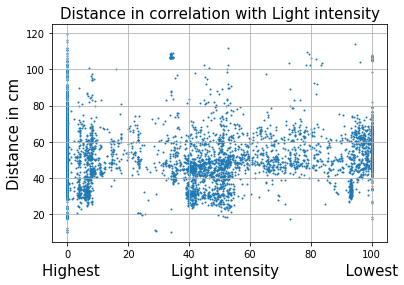

In [7]:
scatter(data_full)

#### Visualisierung der Distanz

Diagramm zur Veranschaulichung der anteiligen Zeit, die in einer bestimmten Distanz verbracht wird. 

Einteilung: 

 - 0 - 40 cm -> kritischer Mindestabstand unterschritten
 - 40 - 60 cm -> Mindestabstand wird eingehalten
 - mehr als 60 cm -> Hinter festem Bildschirmabstand von 60cm, Abstand von den Augen zum Bildschirm bei aufrechter Haltung mit an der Tischkante abgestütztem Körper

In [8]:
def distance_visualization(x):

    distance_u40 = len(x[x.distance <= 40]) 
    distance_o60 = len(x[x.distance > 60]) 
    distance_u60 = (len(x) - distance_u40 - distance_o60)
    
    prec_distance_u40 = distance_u40 / len(x) * 100
    prec_distance_u60 = distance_u60 / len(x) * 100
    prec_distance_o60 = distance_o60 / len(x) * 100
    
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    x_axis = ['Under 40', 'Between 40 & 60', 'Over 60']
    y_axis = [prec_distance_u40, prec_distance_u60, prec_distance_o60]
    plt.xlabel('Distance in cm', fontsize = 15)
    plt.ylabel('Percentage of time', fontsize = 15)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Distance in percentage over time with \n with LED & email warning', fontsize = 15)
    ax.bar(x_axis,y_axis)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{"{0:.2%}".format(height/100)}', (x + width/2, y + height*1.01), ha='center', fontsize = 14)
    
    
    plt.show()
    

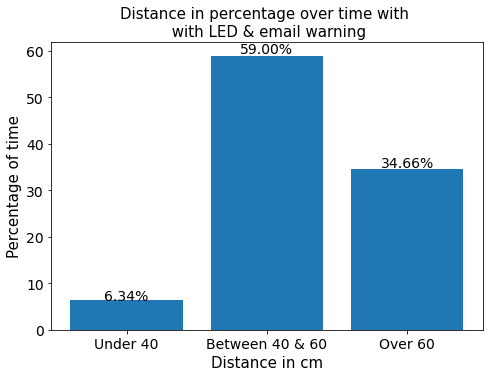

In [9]:
distance_visualization(data_LED_Email)  # Einsetzen eines Dataframes (data_LED_Email, data_LED, data_nowarn, data_full)

#### Visualisierung der Distanz

Diagramm zur Veranschaulichung der anteiligen Zeit, die in einer bestimmter Lichtintensität verbracht wird. 


In [10]:
def light_calculator(x):
    
    light_u20 = len(x[x.light <= 20])
    light_u40 = len(x[x.light <= 40])
    light_u60 = len(x[x.light <= 60])
    light_u80 = len(x[x.light <= 80])
    light_u100 = len(x[x.light <= 100])
    
    light_0_20 = light_u20
    light_20_40 = light_u40 - light_u20
    light_40_60 = light_u60 - light_u40
    light_60_80 = light_u80 - light_u60
    light_80_100 = light_u100 - light_u80
    
    prec_light_0_20 = light_0_20 / len(data_full) * 100
    prec_light_20_40 = light_20_40 / len(data_full) * 100
    prec_light_40_60 = light_40_60 / len(data_full) * 100
    prec_light_60_80 = light_60_80 / len(data_full) * 100
    prec_light_80_100 = light_80_100 / len(data_full) * 100
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    x_axis = ['Max, 0-20', 'High, 20-40', 'Medium, 40-60','Low, 60-80','Min, 80-100']
    y_axis = [prec_light_0_20, prec_light_20_40, prec_light_40_60, prec_light_60_80 ,prec_light_80_100]
    plt.xlabel('Light intensity', fontsize = 16)
    plt.ylabel('Percentage of time', fontsize = 16)
    ax.tick_params(axis='y', which='major', labelsize=13)
    ax.tick_params(axis='x', which='major', labelsize=11.5)
    plt.title('Light intensity in percentage over time', fontsize = 15)
    ax.bar(x_axis,y_axis)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{"{0:.2%}".format(height/100)}', (x + width/2, y + height*1.01), ha='center', fontsize = 12)
    
    
    plt.show()



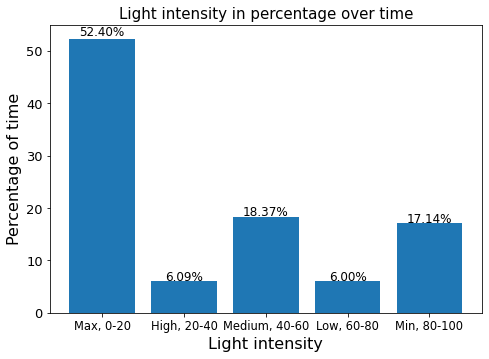

In [11]:
light_calculator(data_full) # Einsetzen eines Dataframes (data_LED_Email, data_LED, data_nowarn, data_full)

#### Untersuchung Schriftgröße

Zur besseren Datenbewertung der Untersuchung wird in der nächsten Darstellung ein Störfaktor näher betrachtet. Hier wird untersucht ob die Schriftgröße oder sonstige Bildschirminhalte von ihrer Größe her einflussreich sind für die weitere Auswertung. Dabei wurde während der Datenerhebung mit den Warnsystemen LED und Email, parralel eine neue Datentabelle erstellt, in der der Benutzer angeben musste ob die Displaydarstellung ausschalggebend für die Distanzunterschreitung war.


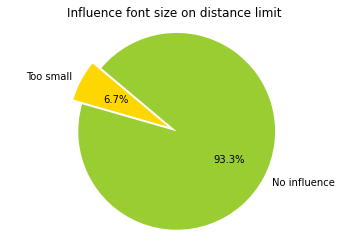

In [12]:
Email_warning = pd.read_excel (r'C:\Users\Julian\Desktop\Master\Industrie 4.0\Email.xlsx') #Please insert own path

Too_small = len(Email_warning.loc[Email_warning['Font size'] == True]) / len(Email_warning) * 100
No_influence = len(Email_warning.loc[Email_warning['Font size'] == False]) / len(Email_warning) * 100

labels = 'Too small', 'No influence'
sizes = [Too_small, No_influence]
colors = ['gold', 'yellowgreen']
explode = (0.1, 0) 

# Plot
plt.pie(sizes, labels=labels, explode = explode, colors=colors,autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.title('Influence font size on distance limit')
plt.show()


#### Visualisierung Anteil Distanz über Lichtintensität

Diagramm zur Darstellung des Anteils der Distanz die verbracht wurde in den verschiedenen Lichtintensitäten.


In [13]:
def distance_over_light (x):
    u40_20 =len(x[(x['distance'] <= 40) & (x['light'] <= 20)])
    u60_20 =len(x[(x['distance'] <= 60) & (x['light'] <= 20)])
    o60_20 =len(x[(x['distance'] > 60) & (x['light'] <= 20)])

    u40_40 =len(x[(x['distance'] <= 40) & (x['light'] <= 40)])
    u60_40 =len(x[(x['distance'] <= 60) & (x['light'] <= 40)])
    o60_40 =len(x[(x['distance'] > 60) & (x['light'] <= 40)])

    u40_60 =len(x[(x['distance'] <= 40) & (x['light'] <= 60)])
    u60_60 =len(x[(x['distance'] <= 60) & (x['light'] <= 60)])
    o60_60 =len(x[(x['distance'] > 60) & (x['light'] <= 60)])

    u40_80 =len(x[(x['distance'] <= 40) & (x['light'] <= 80)])
    u60_80 =len(x[(x['distance'] <= 60) & (x['light'] <= 80)])
    o60_80 =len(x[(x['distance'] > 60) & (x['light'] <= 80)])

    u40_100 =len(x[(x['distance'] <= 40) & (x['light'] <= 100)])
    u60_100 =len(x[(x['distance'] <= 60) & (x['light'] <= 100)])
    o60_100 =len(x[(x['distance'] > 60) & (x['light'] <= 100)])
  
    
    light_u20 = len(x[x.light <= 20])
    light_u40 = len(x[x.light <= 40])
    light_u60 = len(x[x.light <= 60])
    light_u80 = len(x[x.light <= 80])
    light_u100 = len(x[x.light <= 100])
    
    light_0_20 = light_u20
    light_20_40 = light_u40 - light_u20
    light_40_60 = light_u60 - light_u40
    light_60_80 = light_u80 - light_u60
    light_80_100 = light_u100 - light_u80
    
    
    u40_0_20 = u40_20 
    u60_0_20 = u60_20 - u40_0_20
    o60_0_20 = light_u20 - u60_0_20 - u40_0_20

    u40_20_40 = u40_40 - u40_20 
    u60_20_40 = u60_40 - u40_20_40 - u60_20 
    o60_20_40 = light_20_40 - u40_20_40 - u60_20_40

    u40_40_60 = u40_60 - u40_40
    u60_40_60 = u60_60 - u40_40_60 - u60_40
    o60_40_60 = light_40_60 - u40_40_60 - u60_40_60

    u40_60_80 = u40_80 - u40_60
    u60_60_80 = u60_80 - u40_60_80 - u60_60
    o60_60_80 = light_60_80 - u40_60_80 - u60_60_80

    u40_80_100 = u40_100 - u40_80
    u60_80_100 = u60_100 - u40_80_100 - u60_80
    o60_80_100 = light_80_100 - u40_80_100 - u60_80_100
    

    a = u40_0_20 / light_0_20 *100
    b = u60_0_20 / light_0_20 *100
    c = o60_0_20 / light_0_20 *100
    
    a1 = u40_20_40 / light_20_40 *100
    b1 = u60_20_40 / light_20_40 *100
    c1 = o60_20_40 / light_20_40 *100

    a2 = u40_40_60 / light_40_60 *100
    b2 = u60_40_60 / light_40_60 *100
    c2 = o60_40_60 / light_40_60 *100

    a3 = u40_60_80 / light_60_80 *100
    b3 = u60_60_80 / light_60_80 *100
    c3 = o60_60_80 / light_60_80 *100

    a4 = u40_80_100 / light_80_100 *100
    b4 = u60_80_100 / light_80_100 *100
    c4 = o60_80_100 / light_80_100 *100

    x = ['0-20, max', '20-40', '40-60', '60-80','80-100, min']
    y1 = [a,a1,a2,a3,a4]
    y2 = [b,b1,b2,b3,b4]
    y3 = [c,c1,c2,c3,c4]


    plt.bar(x, y1, color='r',label="Under 40")
    plt.bar(x, y2, bottom=y1, color='b',label="Over 40 Under 60")
    plt.bar(x, y3, bottom=[(a+b),(a1+b1),(a2+b2),(a3+b3),(a4+b4)], color='g',label='Over 60')

    plt.title('Proportion of distance within \ndifferent light intensity \n with no warning', fontsize = 15)
    plt.xlabel('Light intensity', fontsize = 16)
    plt.ylabel('Percentage of time for distance \n within intensity', fontsize = 15)

          
    plt.legend()
    plt.show()
    

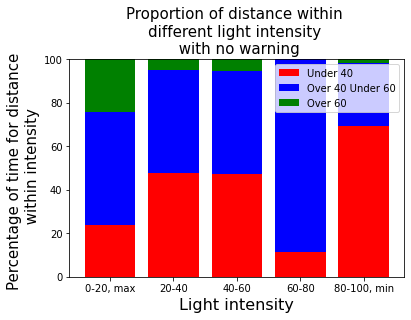

In [14]:
distance_over_light(data_nowarn)